In [ ]:
#import UNet.model_script_ as model_script
import sys
import os
sys.path.append(os.path.abspath('..'))

import config as set_ID
import funcs

# settings
ID = set_ID.ID
LOC = set_ID.LOC

BATCH_SIZE = set_ID.BATCH_SIZE
NUM_EPOCHS = set_ID.NUM_EPOCHS
KERNEL_SIZE = set_ID.KERNEL_SIZE
PADDING = set_ID.PADDING
MODEL_TYPE = set_ID.MODEL_TYPE
TRAIN_START = set_ID.TRAIN_START
TRAIN_END = set_ID.TRAIN_END
VAL_START = set_ID.VAL_START
VAL_END = set_ID.VAL_END
MODELS = set_ID.MODELS
TEST_EXPGROUP = set_ID.TEST_EXPGROUP
TEST_EXP = set_ID.TEST_EXP
TEST_SETTINGS = set_ID.TEST_SETTINGS
T_RES = set_ID.T_RES
VARIABLES_BASE = set_ID.VARIABLES_BASE
VARIABLES_MAX = set_ID.VARIABLES_MAX
VARIABLES_ALL = set_ID.VARIABLES_ALL

IN_CHANNELS = len(VARIABLES_ALL)
TIME_SHIFT_AMOUNT = set_ID.TIME_SHIFT_AMOUNT

MODEL_SAVE_PATH = set_ID.MODEL_SAVE_PATH
MODEL_RECUP_PATH = set_ID.MODEL_RECUP_PATH
MODEL_SAVE_NAME = set_ID.MODEL_SAVE_NAME
DATA_SAVE_PATH = set_ID.DATA_SAVE_PATH

print(set_ID.ID)

month_time_lat_CNRM_skip


In [2]:
# Computational modules 
# %matplotlib inline
import sys
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
import importlib

# Plotting modules 
import matplotlib.pyplot as plt
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import proplot as pplt

# Performance metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import csv
from collections import defaultdict



xr.set_options(display_style='html')
xr.set_options(keep_attrs = True)

ERROR 1: PROJ: proj_create_from_database: Open of /net/nfs/tools/u20/Python/miniconda3_py311_23.11.0-2/envs/pangeo-meso-2024.01.22/share/proj failed


In [3]:
d_sets = {'rsut_test_data':'rsut',
        'predicted_aod':'aod',
        'aod_test_data':'aod'}

# Load in data

In [4]:
data = dict()

for d in d_sets:
    print(d)
    if d == 'predicted_aod':
        data[d] = xr.open_mfdataset(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/{d}_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.nc',
                                                engine="netcdf4")
        print(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/{d}_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.nc')
    else:
        print(f'{DATA_SAVE_PATH}{T_RES}/{d}_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.nc')
        data[d] = xr.open_mfdataset(f'{DATA_SAVE_PATH}{T_RES}/{d}_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.nc',
                                                engine="netcdf4")

    # resample daily output to monthly averages
    if 'month' not in T_RES:
        data[d] = data[d].resample(time="M").mean()

rsut_test_data
/homedata/sbaur/MRV-project/NN_model/UNet/month/rsut_test_data_CNRM-CERFACS_2031-2032.nc
predicted_aod
/homedata/sbaur/MRV-project/NN_model/UNet/bs256_mems30_models1_1950-1979_month_time_lat_CNRM_skip/predicted_aod_CNRM-CERFACS_2031-2032.nc
aod_test_data
/homedata/sbaur/MRV-project/NN_model/UNet/month/aod_test_data_CNRM-CERFACS_2031-2032.nc


### Get global mean

# Plot

In [5]:
d_sets

{'rsut_test_data': 'rsut', 'predicted_aod': 'aod', 'aod_test_data': 'aod'}

/homedata/sbaur/MRV-project/NN_model/UNet/bs256_mems30_models1_1950-1979_month_time_lat_CNRM_skip/AOD_prediction_CNRM-CERFACS_2031-2032.png


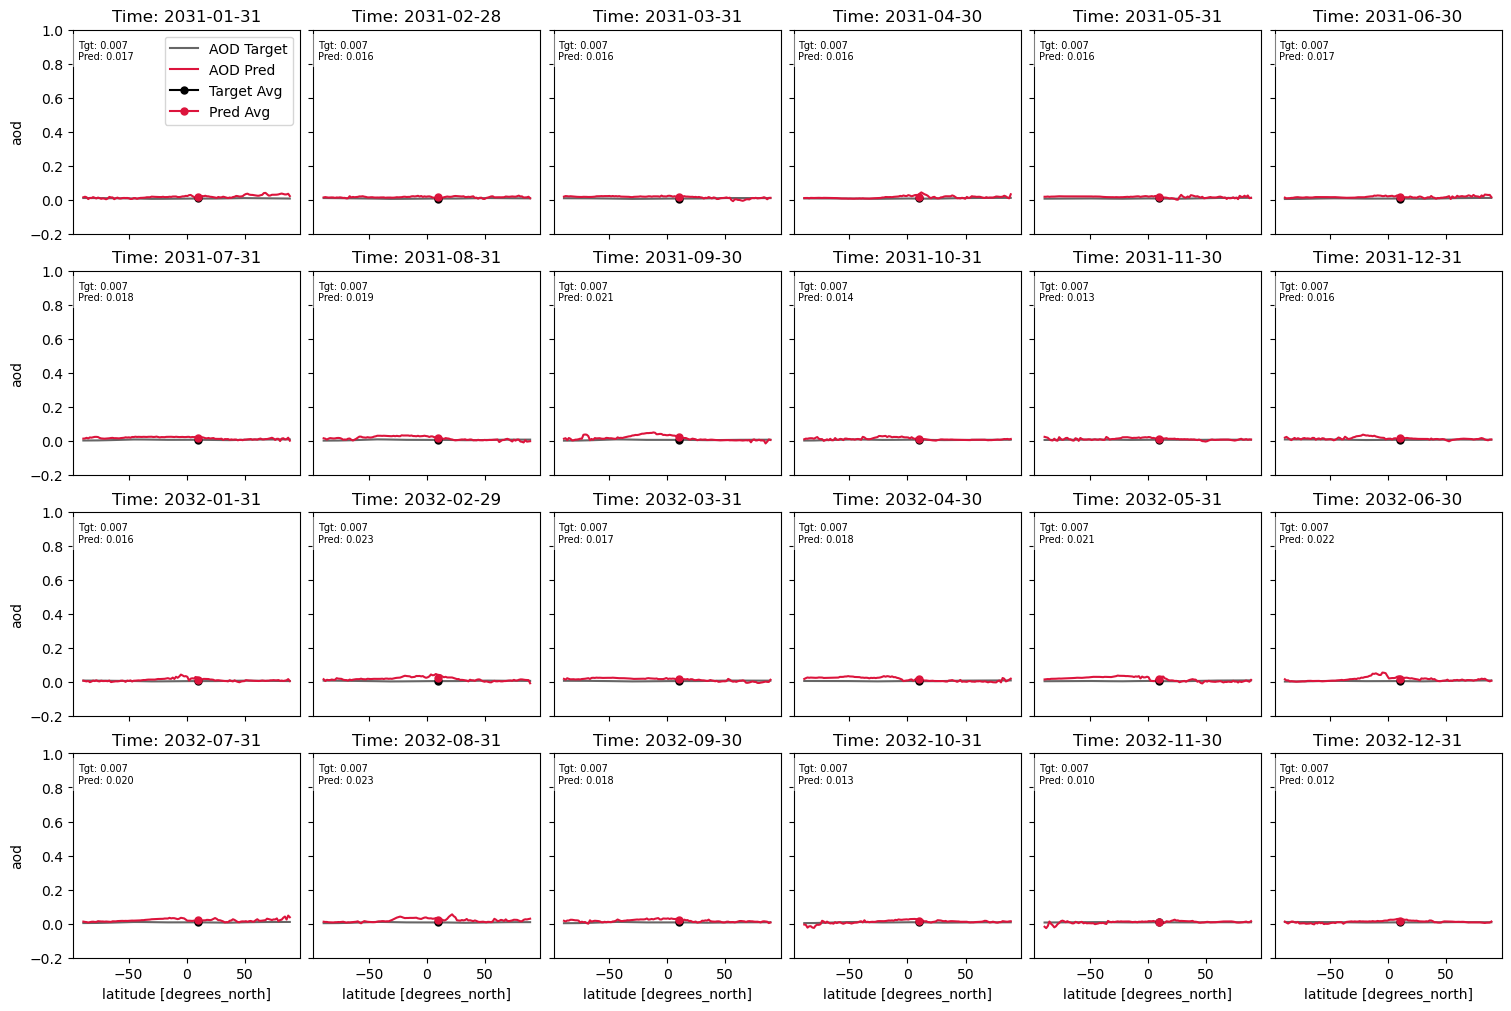

In [6]:
# Extract the time coordinates
time_values = data["aod_test_data"]["time"].values

# Create a cosine latitude weight array
latitudes = data["aod_test_data"]["lat"]
weights = np.cos(np.deg2rad(latitudes))

# Normalize weights so they sum to 1 (over latitude only)
weights /= weights.sum()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, t in enumerate(time_values):
    ax = axes[i]
    
    target_data = data["aod_test_data"]['aod'].sel(time=t)
    pred_data = data["predicted_aod"]['aod'].sel(time=t)

    # Compute area-weighted global averages
    target_avg = (target_data.weighted(weights).mean(dim=["lat"])).values.item()
    pred_avg = (pred_data.weighted(weights).mean(dim=["lat"])).values.item()

    # Plot
    target_data.plot(ax=ax, label="AOD Target", color="black", alpha=0.6)
    pred_data.plot(ax=ax, label="AOD Pred", color="crimson")

    # Plot global average as scatter points (place them at a dummy lat/lon location, e.g., lat=-85, lon=-170)
    ax.plot(10, target_avg, marker='o', color='black', markersize=5, label='Target Avg')  # target point
    ax.plot(10, pred_avg, marker='o', color='crimson', markersize=5, label='Pred Avg')  
    
    ax.set_title(f"Time: {str(t)[:10]}")

    # Add global average text
    ax.text(0.02, 0.95, f"Tgt: {target_avg:.3f}\nPred: {pred_avg:.3f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    ax.set_ylim(-0.2, 1)

    if i % 6 != 0:
        ax.set_ylabel("")
    if i < 18:
        ax.set_xlabel("")

axes[0].legend(loc="best")

# Save and show
plt.savefig(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
print(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
plt.show()

/homedata/sbaur/MRV-project/NN_model/UNet/bs256_mems30_models1_1950-1979_month_time_lat_IPSL_skip/AOD_prediction_IPSL_2091-2092.png


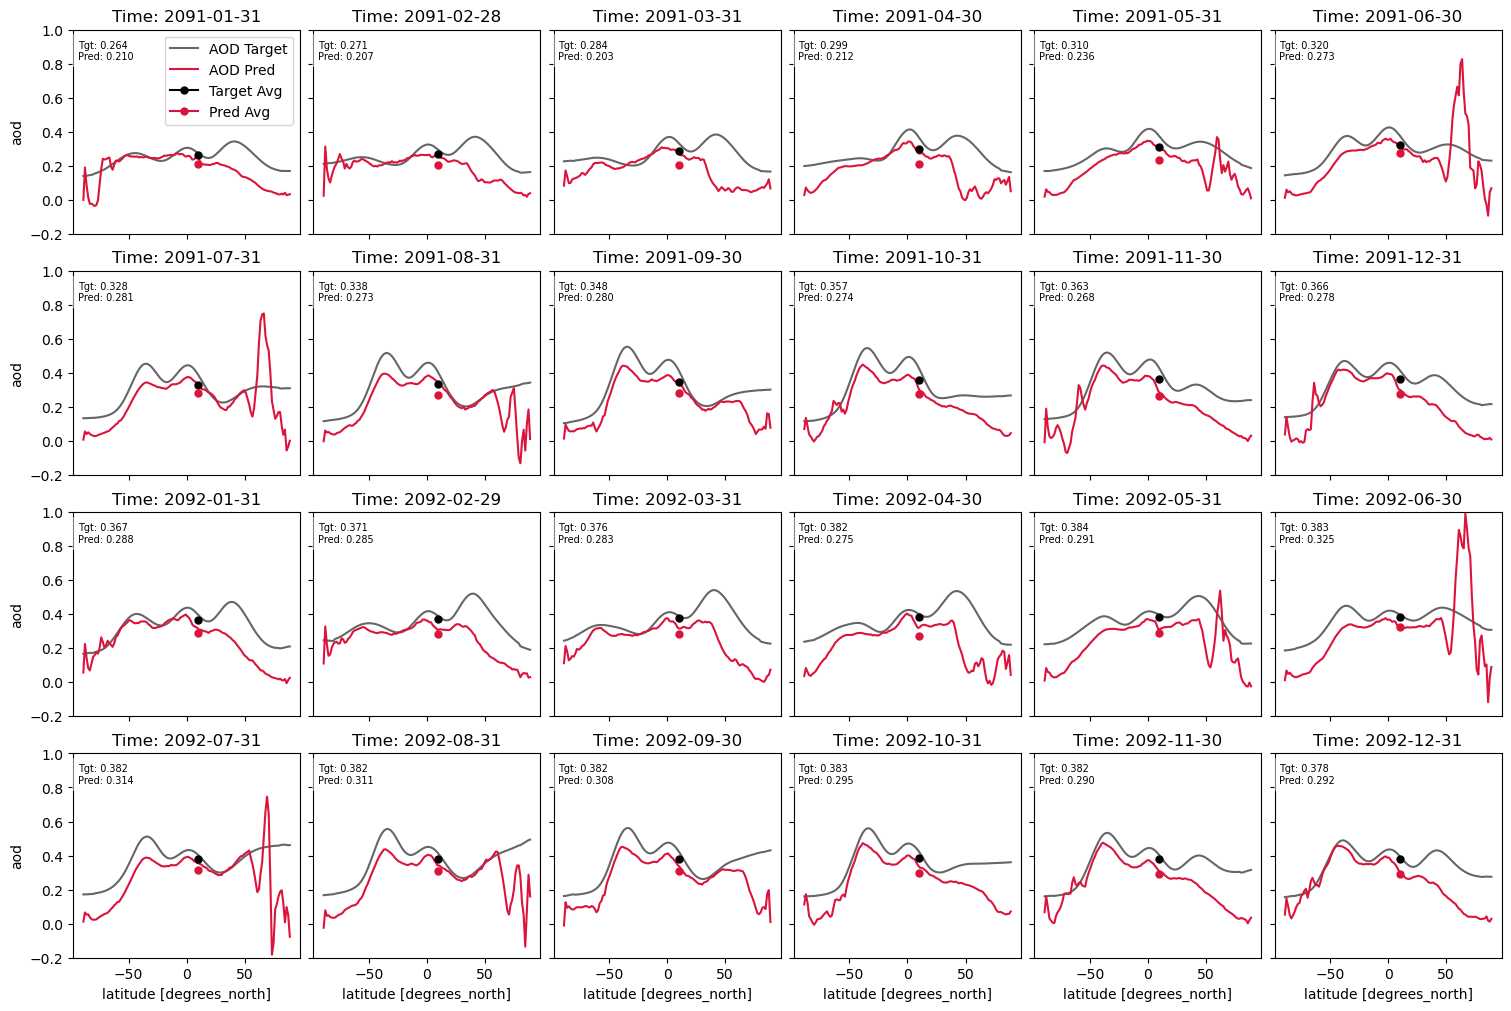

In [29]:
# Extract the time coordinates
time_values = data["aod_test_data"]["time"].values

# Create a cosine latitude weight array
latitudes = data["aod_test_data"]["lat"]
weights = np.cos(np.deg2rad(latitudes))

# Normalize weights so they sum to 1 (over latitude only)
weights /= weights.sum()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, t in enumerate(time_values):
    ax = axes[i]
    
    target_data = data["aod_test_data"]['aod'].sel(time=t)
    pred_data = data["predicted_aod"]['aod'].sel(time=t)

    # Compute area-weighted global averages
    target_avg = (target_data.weighted(weights).mean(dim=["lat"])).values.item()
    pred_avg = (pred_data.weighted(weights).mean(dim=["lat"])).values.item()

    # Plot
    target_data.plot(ax=ax, label="AOD Target", color="black", alpha=0.6)
    pred_data.plot(ax=ax, label="AOD Pred", color="crimson")

    # Plot global average as scatter points (place them at a dummy lat/lon location, e.g., lat=-85, lon=-170)
    ax.plot(10, target_avg, marker='o', color='black', markersize=5, label='Target Avg')  # target point
    ax.plot(10, pred_avg, marker='o', color='crimson', markersize=5, label='Pred Avg')  
    
    ax.set_title(f"Time: {str(t)[:10]}")

    # Add global average text
    ax.text(0.02, 0.95, f"Tgt: {target_avg:.3f}\nPred: {pred_avg:.3f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    ax.set_ylim(-0.2, 1)

    if i % 6 != 0:
        ax.set_ylabel("")
    if i < 18:
        ax.set_xlabel("")

axes[0].legend(loc="best")

# Save and show
plt.savefig(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
print(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_MODEL"][0]}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
plt.show()

/homedata/sbaur/MRV-project/NN_model/UNet/bs256_mems30_models2_1950-1979_month_time_lat_bothmodels_skip/AOD_prediction_2091-2092.png


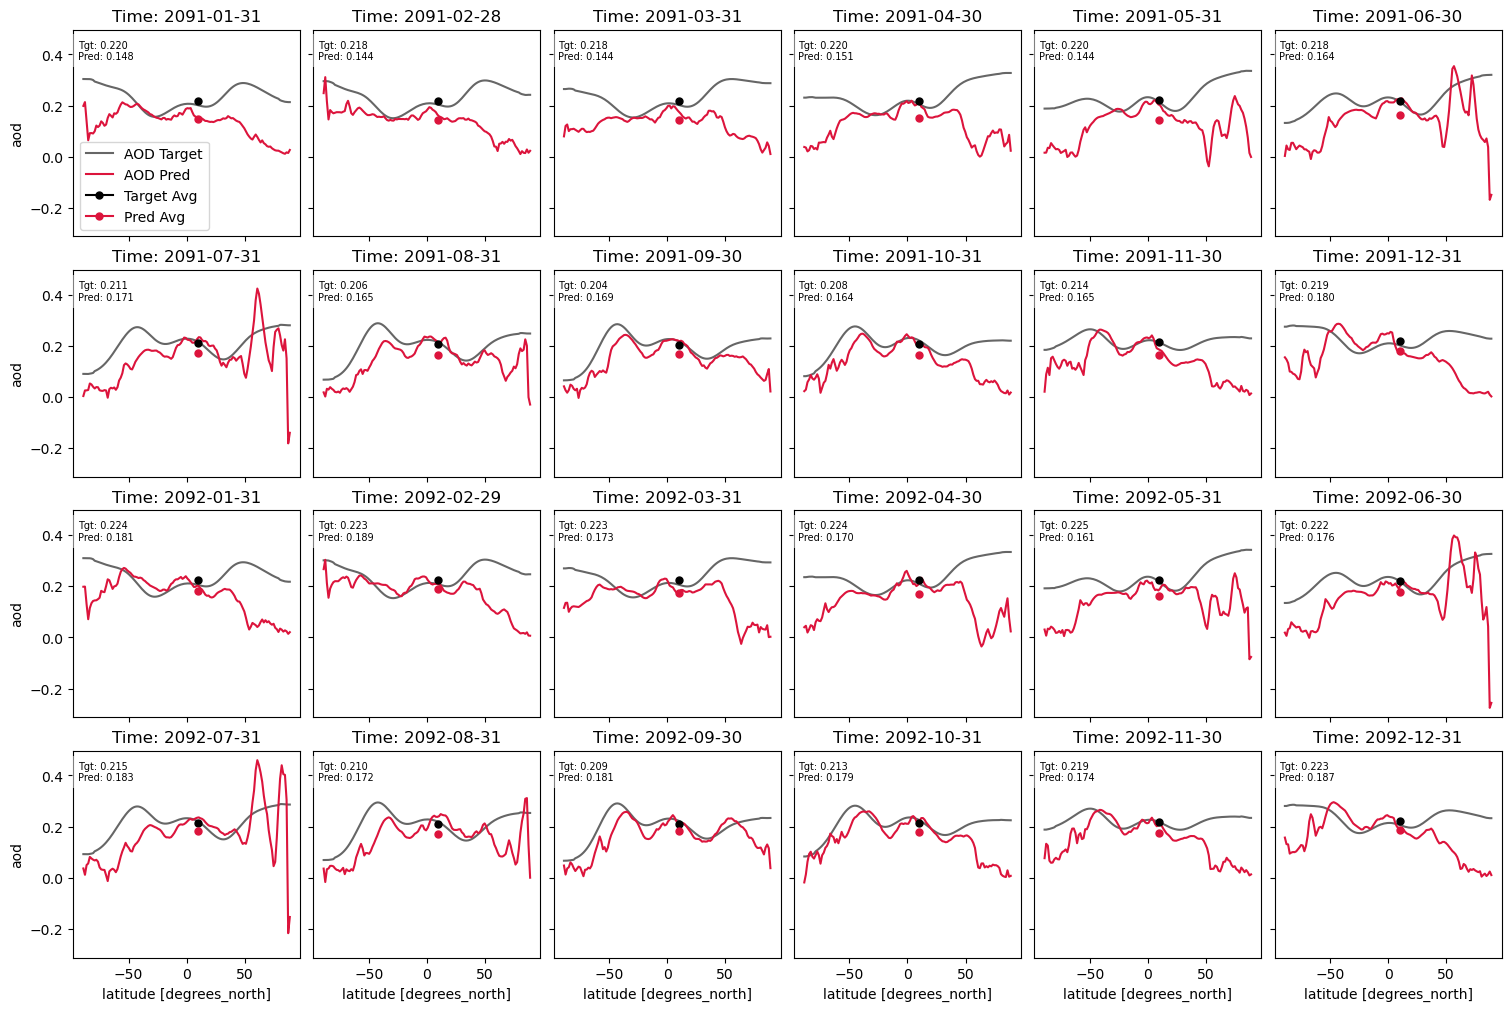

In [6]:
# Extract the time coordinates
time_values = data["aod_test_data"]["time"].values

# Create a cosine latitude weight array
latitudes = data["aod_test_data"]["lat"]
weights = np.cos(np.deg2rad(latitudes))

# Normalize weights so they sum to 1 (over latitude only)
weights /= weights.sum()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, t in enumerate(time_values):
    ax = axes[i]
    
    target_data = data["aod_test_data"]['aod'].sel(time=t)
    pred_data = data["predicted_aod"]['aod'].sel(time=t)

    # Compute area-weighted global averages
    target_avg = (target_data.weighted(weights).mean(dim=["lat"])).values.item()
    pred_avg = (pred_data.weighted(weights).mean(dim=["lat"])).values.item()

    # Plot
    target_data.plot(ax=ax, label="AOD Target", color="black", alpha=0.6)
    pred_data.plot(ax=ax, label="AOD Pred", color="crimson")

    # Plot global average as scatter points (place them at a dummy lat/lon location, e.g., lat=-85, lon=-170)
    ax.plot(10, target_avg, marker='o', color='black', markersize=5, label='Target Avg')  # target point
    ax.plot(10, pred_avg, marker='o', color='crimson', markersize=5, label='Pred Avg')  
    
    ax.set_title(f"Time: {str(t)[:10]}")

    # Add global average text
    ax.text(0.02, 0.95, f"Tgt: {target_avg:.3f}\nPred: {pred_avg:.3f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    if i % 6 != 0:
        ax.set_ylabel("")
    if i < 18:
        ax.set_xlabel("")

axes[0].legend(loc="best")

# Save and show
plt.savefig(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
print(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
plt.show()

/homedata/sbaur/MRV-project/NN_model/UNet/bs256_mems30_models2_1950-1979_month_time_lat_bothmodels_cs/AOD_prediction_2068-2069.png


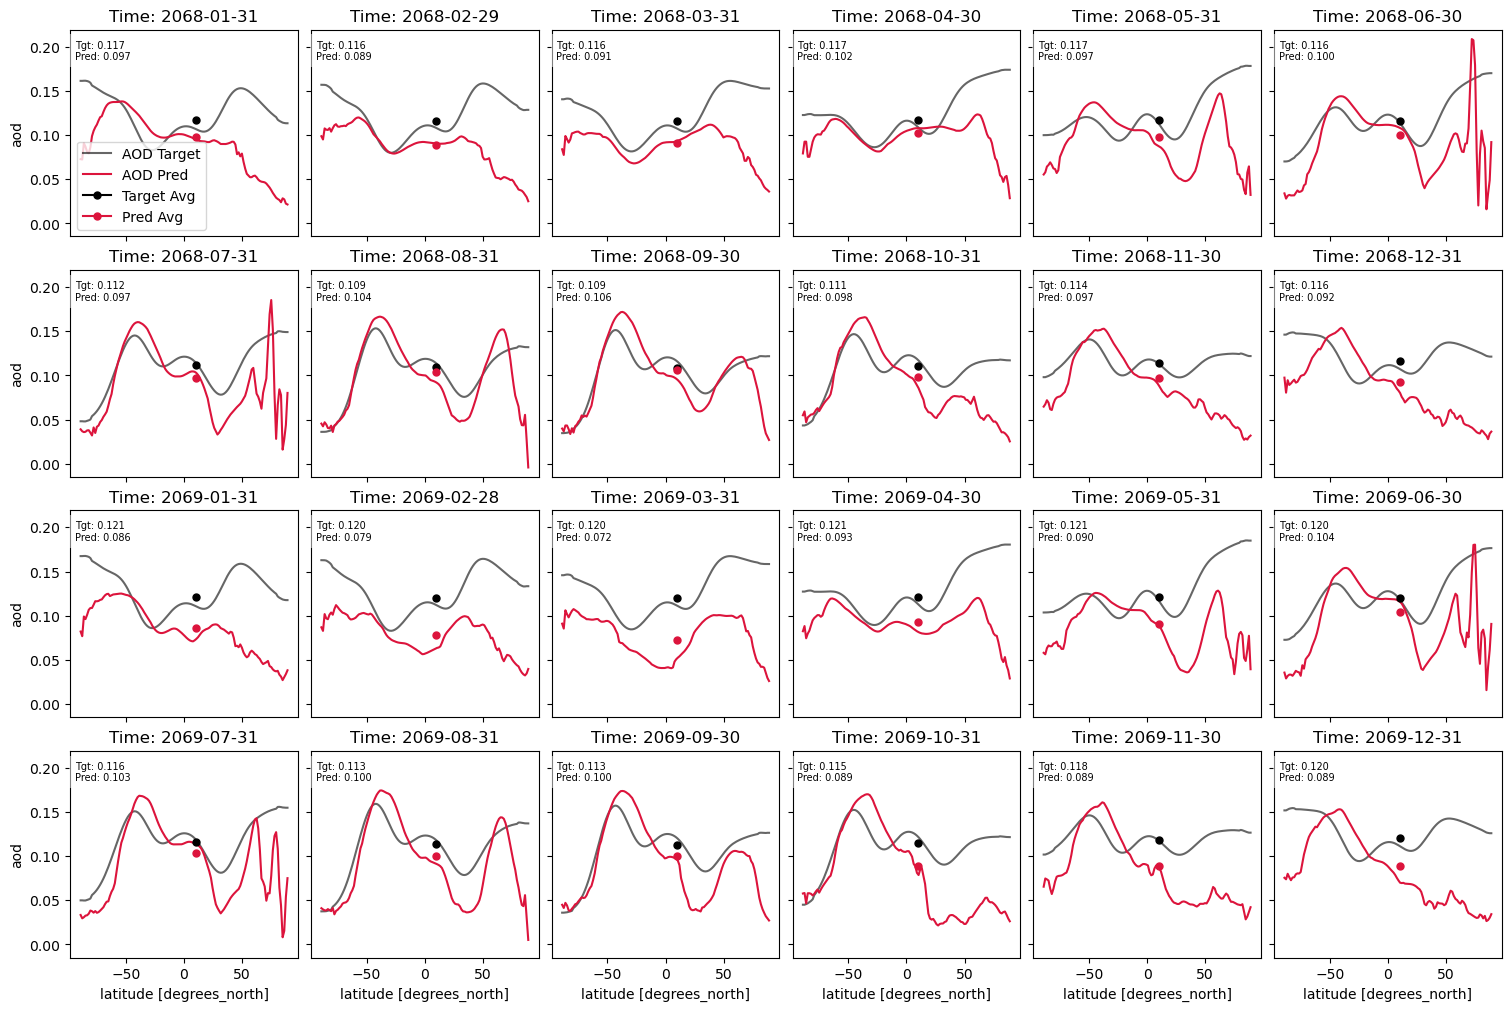

In [5]:
# Extract the time coordinates
time_values = data["aod_test_data"]["time"].values

# Create a cosine latitude weight array
latitudes = data["aod_test_data"]["lat"]
weights = np.cos(np.deg2rad(latitudes))

# Normalize weights so they sum to 1 (over latitude only)
weights /= weights.sum()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, t in enumerate(time_values):
    ax = axes[i]
    
    target_data = data["aod_test_data"]['aod'].sel(time=t)
    pred_data = data["predicted_aod"]['aod'].sel(time=t)

    # Compute area-weighted global averages
    target_avg = (target_data.weighted(weights).mean(dim=["lat"])).values.item()
    pred_avg = (pred_data.weighted(weights).mean(dim=["lat"])).values.item()

    # Plot
    target_data.plot(ax=ax, label="AOD Target", color="black", alpha=0.6)
    pred_data.plot(ax=ax, label="AOD Pred", color="crimson")

    # Plot global average as scatter points (place them at a dummy lat/lon location, e.g., lat=-85, lon=-170)
    ax.plot(10, target_avg, marker='o', color='black', markersize=5, label='Target Avg')  # target point
    ax.plot(10, pred_avg, marker='o', color='crimson', markersize=5, label='Pred Avg')  
    
    ax.set_title(f"Time: {str(t)[:10]}")

    # Add global average text
    ax.text(0.02, 0.95, f"Tgt: {target_avg:.3f}\nPred: {pred_avg:.3f}", transform=ax.transAxes,
            fontsize=7, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    if i % 6 != 0:
        ax.set_ylabel("")
    if i < 18:
        ax.set_xlabel("")

axes[0].legend(loc="best")

# Save and show
plt.savefig(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
print(f'{DATA_SAVE_PATH}{MODEL_SAVE_NAME[:-4]}/AOD_prediction_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.png')
plt.show()

# Export performance metrics

In [6]:
# calculate average RMSE per latitude? -> spatial RMSE

In [7]:
rmse = dict()
rmse_pct=dict()
r = dict()

y_avg = data['aod_test_data']['aod'].mean('time').mean('lat').values.item()

for t in data['predicted_aod']['aod'].time:
    # mse = mean_squared_error(data['predicted_aod']['aod'].sel(time=t), data['aod_test_data']['aod'].sel(time=t))
    # rmse[str(t.values)[:7]] = round(np.sqrt(mse), 2)
    # r_interim, _ = pearsonr(data['predicted_aod']['aod'].sel(time=t), data['aod_test_data']['aod'].sel(time=t))
    # r[str(t.values)[:7]] = round(r_interim, 2)


    y_pred = data['predicted_aod']['aod'].sel(time=t)
    y_true = data['aod_test_data']['aod'].sel(time=t)

    mse = mean_squared_error(y_true, y_pred)
    rmse_val = np.sqrt(mse)
    #mean_true = np.mean(y_true).values.item() 
    mean_true = y_avg
    

    rmse[str(t.values)[:7]] = round(rmse_val, 2)
    rmse_pct[str(t.values)[:7]] = round((rmse_val / mean_true) * 100, 1)

    r_interim, _ = pearsonr(y_pred, y_true)
    r[str(t.values)[:7]] = round(r_interim, 2)

In [8]:
importlib.reload(funcs)

avg_r = funcs.average_metrics_6month(r)
avg_rmse = funcs.average_metrics_6month(rmse)
avg_rmse_pct = funcs.average_metrics_6month(rmse_pct)

funcs.log_metrics(MODEL_SAVE_NAME[:-4], ID, avg_r, avg_rmse, avg_rmse_pct, f'{DATA_SAVE_PATH}model_performance_log_{TEST_EXP}_{TEST_SETTINGS["TEST_YEAR"][0]}-{TEST_SETTINGS["TEST_YEAR"][-1]}.csv')

/homedata/sbaur/MRV-project/NN_model/UNet/model_performance_log_G6sulfur_2031-2032.csv
